# Brain Tumor Classification

### 1. Dataset Overview
This project combines multiple public brain tumor MRI image datasets to build a 4-class classifier for:
- **Glioma**  
- **Meningioma**  
- **Pituitary Tumor**  
- **No Tumor**  

### Class Definitions
| Class          | Description |
|----------------|-------------|
| **Glioma**     | Tumors originating from glial cells; includes astrocytomas, oligodendrogliomas, and glioblastomas. |
| **Meningioma** | Benign tumors arising from the meninges (outer layers of the brain). |
| **Pituitary Tumor** | Usually benign tumors that develop in the pituitary gland at the base of the brain. |
| **No Tumor**   | MRI scans without any detectable tumor. |


### 2. Class Distributions
Before training, it's essential to understand how many samples exist per class. Imbalanced data can bias the model toward overpredicting majority classes.

We’ll examine the sample counts across all datasets and visualize the overall distribution.


{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


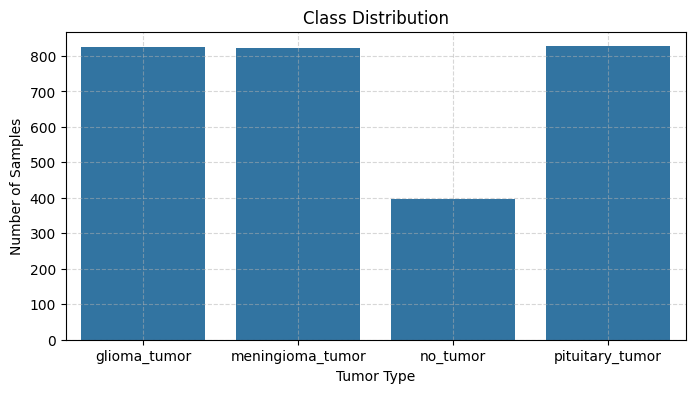

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# define path
data_dir = r"C:\Users\SCHOOL\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\3\Training"

# count samples
def count_samples(directory):
    return {
        cls: len(os.listdir(os.path.join(directory, cls))) 
        for cls in os.listdir(directory) 
        if os.path.isdir(os.path.join(directory, cls))
    }

# get counts
counts = count_samples(data_dir)
print(counts)

# plot class distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Tumor Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("../reports/class_distribution.png", bbox_inches="tight")
plt.show()

From what we can see above:
- Tumor classes contain the following sample counts:  
  - Glioma: 826  
  - Meningioma: 822  
  - Pituitary: 827  
  - No Tumor: 395
- There is some imbalance, with the “no tumor” class being smaller than the others, but the difference is moderate.
- No oversampling or class weighting is required, as the imbalance is unlikely to significantly bias the model during training.



### 3. Image Quality

To ensure our model learns meaningul patterns from the input images, we need to make sample visualizations

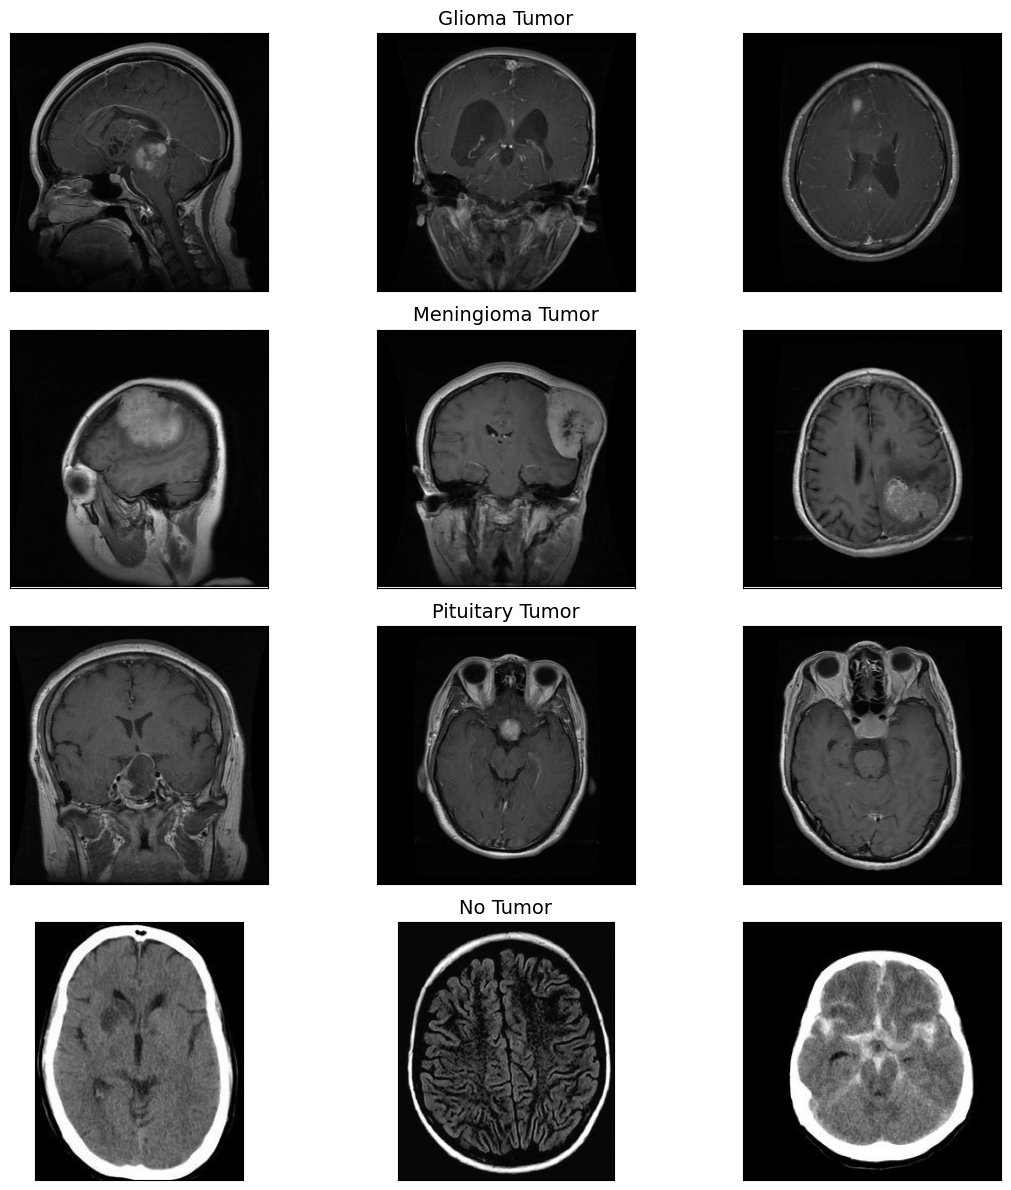

In [12]:
# seed for reproducibility
np.random.seed(55)

# load N random images from a class folder
def load_n_images(class_name, n=3):
    class_path = os.path.join(data_dir, class_name)
    files = np.array(os.listdir(class_path))
    selected_files = np.random.choice(files, size=n, replace=False)
    return [Image.open(os.path.join(class_path, f)).convert("L") for f in selected_files]  # Load as grayscale

# load 3 images per class
glioma_imgs = load_n_images("glioma_tumor", n=3)
meningioma_imgs = load_n_images("meningioma_tumor", n=3)
pituitary_imgs = load_n_images("pituitary_tumor", n=3)
no_tumor_imgs = load_n_images("no_tumor", n=3)

# plot all images
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# glioma row
for i, img in enumerate(glioma_imgs):
    axes[0, i].imshow(img, cmap="gray")
    if i == 1:
        axes[0, i].set_title("Glioma Tumor", fontsize=14)

# meningioma row
for i, img in enumerate(meningioma_imgs):
    axes[1, i].imshow(img, cmap="gray")
    if i == 1:
        axes[1, i].set_title("Meningioma Tumor", fontsize=14)

# pituitary row
for i, img in enumerate(pituitary_imgs):
    axes[2, i].imshow(img, cmap="gray")
    if i == 1:
        axes[2, i].set_title("Pituitary Tumor", fontsize=14)

# no tumor row
for i, img in enumerate(no_tumor_imgs):
    axes[3, i].imshow(img, cmap="gray")
    if i == 1:
        axes[3, i].set_title("No Tumor", fontsize=14)

# remove ticks and add some spacing
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.savefig("../reports/image_quality_comparison.png", bbox_inches="tight", dpi=300)
plt.show()

Looking at the plotted images:

- All images appear to have similar contrast and uniform size.
- Variations in tumor location and scanning angle will help the model learn diverse features.


### 4. Model Plan

The model setup for this project will include:

- **Transfer learning**  
  Use an EfficientNetV2-Small pretrained on ImageNet and replace the final head. This provides strong feature representations and speeds up convergence on a small dataset.

- **AutoAugment**  
  Automatically applies a set of learned augmentation policies (rotations, color/brightness changes, crops, etc.) to increase data diversity and reduce overfitting.

- **Efficient data loading**  
  Use `DataLoader` with an appropriate `batch_size`, `num_workers`, `pin_memory`, and `persistent_workers` so disk I/O and preprocessing don’t bottleneck GPU training.

- **Mixed precision training**  
  Use `torch.cuda.amp` to speed up training and reduce memory usage by computing in float16 where safe.

- **Optimizer & weight decay**  
  Use a modern optimizer with weight decay to help generalization by penalizing large weights.

- **Learning rate scheduling**  
  Use a scheduler to vary the learning rate during training — helps faster convergence and better final performance.

- **Dropout**  
  Apply dropout in the classifier head to reduce overfitting by randomly deactivating neurons during training.

- **Checkpointing & early stopping**  
  Save best model checkpoints based on validation performance and stop training if metrics plateau to prevent overfitting.

- **Metrics & epoch stats**  
  Track training/validation loss, accuracy, and **macro F1** each epoch, plus per-class precision/recall and a confusion matrix for error analysis.

- **Grad-CAM**  
  Visualize model attention maps on example images to verify that the network focuses on clinically relevant regions.
